In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.chdir('..')
import rwpropa as rw

### Source

In [2]:
nr_particles = 4*10**3
source_pos = np.array([0.0, 0.0, 0.0], dtype=np.float32)
energy = 10**12 # eV
sphere = 10**14 # [m]

def point_source(nr_particles=nr_particles):
    return rw.PointSourceIsotropic(energy, source_pos, nr_particles)

def sphere_source(nr_particles=nr_particles):
    radius = sphere
    source = rw.SphereSourceIsotropic(energy, source_pos, nr_particles, radius)
    return source

### Propagator

In [3]:
step_size = 1.0*10**11

def propagator(nr_steps=1*10**4, step_size=step_size, diff=1.5*10**21):
    speed_of_light = 3*10**8 # [m/s]
    diffusion_coefficient = diff # [m^2/s]
    mfp_iso = 3*diffusion_coefficient/speed_of_light
    mfp = np.array([mfp_iso, mfp_iso, mfp_iso], dtype=np.float32)  # [m]
    prop = rw.IsotropicPropagator(mfp, nr_steps, step_size)
    return prop

### Observer

In [4]:
def time_evolution_observer(nr_steps):
    substeps = [False, False, True] # observe only steps (no substeps)
    min_step = 1
    max_step = nr_steps
    nr_obs_steps = 30
    observer = rw.TimeEvolutionObserverLog(min_step, max_step, nr_obs_steps, substeps)
    return observer

def sphere_observer():
    substeps = [False, False, True] # observe only steps (no substeps)
    spheres = [sphere]
    return rw.SphericalObserver(substeps, spheres, on_detection_deactivate=True)

### Simulation & Analyze setup

In [5]:
def run_simulation(source, observer, propagator, file_name):
    sim = rw.Simulation()
    sim.add_source(source)
    sim.add_propagator(propagator)
    sim.add_observer(observer)
    %time sim.run_simulation()
    sim.save_data(file_name)

In [6]:
def analize(file_name, diff):
    df = pd.read_pickle(file_name+'.pkl')
    bins = 20
    trajectory_lengths = df['d']
    d = trajectory_lengths/10**14
    hist, bins = np.histogram(d, bins=bins)
    logbins = np.logspace(np.log10(min(d)),np.log10(max(d)),len(bins))
    plt.hist(d, bins=logbins, alpha=0.5, label='$\kappa =$ {:.1e}m$^2$/s'.format(diff))

    plt.title('total # particles = {:.0e}'.format(nr_particles))
    plt.xlabel('D/{:.0e}m'.format(sphere))
    plt.ylabel('# particles')
    plt.loglog()
    plt.legend()
    plt.show()

###  Simulation

In [7]:
diff = 10**21 #[m^2/s]
step_size=1.0*10**12

Observer initialized
Propagator initialized
start simulation
CPU times: user 16.6 s, sys: 39.4 ms, total: 16.7 s
Wall time: 16.7 s
saved data file data/data_tut_5_point_time_kappa.pkl
init statistics plotting class


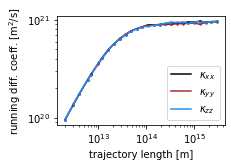

diffusion coefficients computed between 9.95e+14m and 3.00e+15m with 5 data points
kappa_{xx}: 9.6e+20 m²/s +- 8.52e+18 m²/s
kappa_{yy}: 9.39e+20 m²/s +- 2.05e+19 m²/s
kappa_{zz}: 9.61e+20 m²/s +- 6.67e+18 m²/s
particle distribution after 1. step


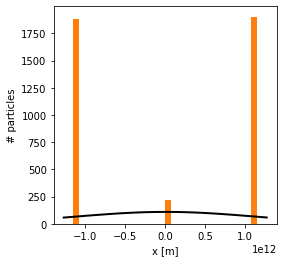

particle distribution after last step


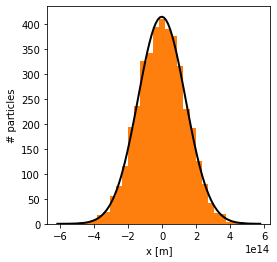

In [8]:
file_0 = 'data/data_tut_5_point_time_kappa'
nr_steps = 3*10**3
run_simulation(point_source(nr_particles=4*10**3), time_evolution_observer(nr_steps=nr_steps), propagator(step_size=step_size, diff=diff, nr_steps=nr_steps), file_0)
df = pd.read_pickle(file_0+'.pkl')
sta = rw.Statistics(df)
df_kappas = sta.plot_diffusion_coefficients(n_points_plateau=5)

steps = sorted(list(set(df['i'])))
print('particle distribution after 1. step')
sta.plot_distribution('x', steps[0], 50, None)
print('particle distribution after last step')
sta.plot_distribution('x', steps[-1], 50, None)

Observer initialized
Propagator initialized
start simulation
CPU times: user 14 s, sys: 19.7 ms, total: 14.1 s
Wall time: 14 s
saved data file data/data_tut_5_source_time_distr.pkl
init statistics plotting class
particle distribution after 1. step


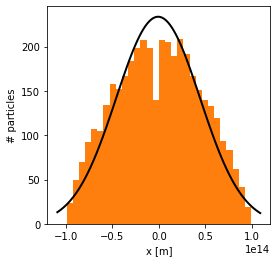

particle distribution after last step


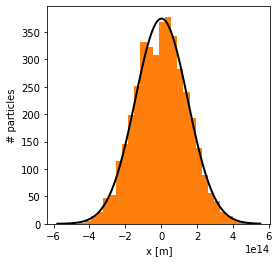

In [9]:
file_1 = 'data/data_tut_5_source_time_distr'
nr_steps=3*10**3
run_simulation(sphere_source(nr_particles=4*10**3), time_evolution_observer(nr_steps=nr_steps), propagator(step_size=step_size, diff=diff, nr_steps=nr_steps), file_1)
df = pd.read_pickle(file_1+'.pkl')
sta = rw.Statistics(df)
steps = sorted(list(set(df['i'])))
print('particle distribution after 1. step')
sta.plot_distribution('x', steps[0], 50, None)
print('particle distribution after last step')
sta.plot_distribution('x', steps[-1], 50, None)

Observer initialized
Propagator initialized
start simulation
CPU times: user 3.17 s, sys: 19 µs, total: 3.17 s
Wall time: 3.17 s
saved data file data/data_tut_5_point_sphere_hist.pkl


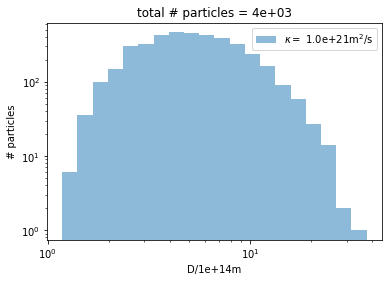

In [10]:
file_2 = 'data/data_tut_5_point_sphere_hist'
run_simulation(point_source(), sphere_observer(), propagator(step_size=step_size, diff=diff, nr_steps=1*10**4), file_2)
analize(file_2, diff)

Observer initialized
Propagator initialized
start simulation
CPU times: user 1.64 s, sys: 13 µs, total: 1.64 s
Wall time: 1.64 s
saved data file data/data_tut_5_sphere_sphere.pkl


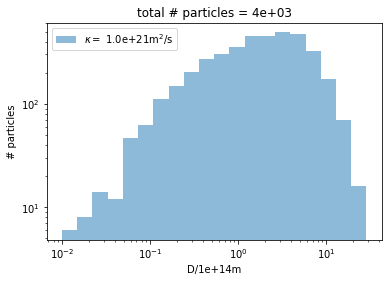

In [11]:
file_3 = 'data/data_tut_5_sphere_sphere'
run_simulation(sphere_source(), sphere_observer(), propagator(step_size=step_size, diff=diff, nr_steps=1*10**4), file_3)
analize(file_3, diff)

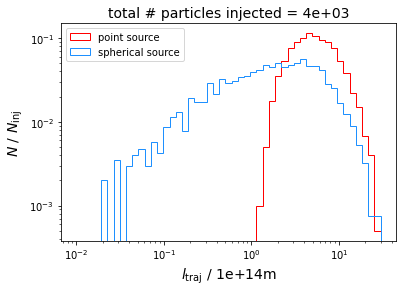

In [12]:
colors = ['r', 'dodgerblue']
labels = ['point source', 'spherical source']
bins = 50
logbins = np.logspace(np.log10(step_size/sphere), np.log10(step_size*nr_steps/sphere),bins)

for i, file in enumerate([file_2, file_3]):
    df = pd.read_pickle(file+'.pkl')
    trajectory_lengths = df['d']
    d = trajectory_lengths/sphere
    weights = np.ones_like(d)/nr_particles
    plt.hist(d, bins=logbins, weights=weights, histtype=u'step', edgecolor=colors[i], linewidth=1., facecolor="None", label=labels[i])
    #plt.axvline(x=transitions[i]/sphere, color=colors[i], ls='--')

plt.title('total # particles injected = {:.0e}'.format(nr_particles), size=14)
plt.xlabel('$l_\mathrm{traj}$'+' / {:.0e}m'.format(sphere), size=14)
plt.ylabel('$N$ / $N_\mathrm{inj}$', size=14)
plt.loglog()
plt.legend(loc = "upper left")
#plt.savefig('traj_lengths_rwpropa_normalized.pdf')
plt.show()